In [1]:
!pip install -q transformers  rouge-score  


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.8 MB/s eta 0:00:00


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
import pandas as pd 
import transformers
from torch.utils.data import Dataset, DataLoader 


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name) 

import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm
  
import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt




Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
 
import os 
  
sum_dir = "/content/drive/MyDrive/mlexperiments/extractivesummarization/models/extractive_tf"


In [ ]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 17 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cnn_df = pd.read_csv('/content/drive/MyDrive/summ_df.csv')
cnn_df.head()

,Unnamed: 0,titles,abstracts,sections,summaries,citations
0,0,TnT - A Statistical Part-Of-Speech Tagger,Trigrams'n'Tags (TnT) is an efficient statisti...,A large number of current language processing ...,TnT - A Statistical Part-Of-Speech Tagger\nTri...,The sentences in the DSO collection were tagge...
1,1,Sentence Reduction For Automatic Text Summariz...,Figure 2: Sample sentence and parse tree we ha...,Current automatic summarizers usually rely on ...,Sentence Reduction For Automatic Text Summariz...,"In fact, professional abstractors tend to use..."
2,2,Advances In Domain Independent Linear Text Seg...,This paper describes a method for linear text ...,Even moderately long documents typically addre...,Advances In Domain Independent Linear Text Seg...,"Choi (2000) used the rank of the cosine, rathe..."
3,3,A Simple Approach To Building Ensembles Of Nai...,This paper presents a corpus-based approach to...,Word sense disambiguation is often cast as a p...,A Simple Approach To Building Ensembles Of Nai...,We have presented an ensemble approach to word...
4,4,A Maximum-Entropy-Inspired Parser,We present a new parser for parsing down to Pe...,We present a new parser for parsing down to Pe...,A Maximum-Entropy-Inspired Parser\nWe present ...,"As a benchmark VPC extraction system, we use ..."


In [ ]:
cnn_df['article'] = cnn_df['abstracts'].map(str) + ' ' + cnn_df['citations'].map(str)

In [ ]:
from rouge_score import rouge_scorer 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def get_rougue_score(text, highlights, metric="rougeL"):
  max_score = 0
  for h_text in highlights:
    score =  scorer.score(text, h_text)[metric].fmeasure
    # print(score, text, "\n \t" , h_text)
    if score > max_score:
      max_score = score 
  return max_score 


def get_label(sent, doc_dict,  score_threshold = 0.55):
  sent_id, doc_id, sentence = sent["sentid"], sent["docid"], sent["text"]  
  highlights = doc_dict[doc_id]["highlight"].split("\n")
  doc = doc_dict[doc_id]["article"]

  label_score = get_rougue_score(sentence, highlights) 
  # Normalize label to 0/1 based on rogue score threshold
  label_score = 0 if label_score < score_threshold else 1 
  return (sentence, doc, label_score)
  
def sub_sample(sents_batch, doc_dict, neg_multiplier=2):
  # get labels 
  vals = [get_label(x, doc_dict)  for x in sents_batch] 

  # construct arrays of sentences, corresponding documents and labels  
  sents, docs, y = [], [], [] 
  for row in vals:
    sents.append(row[0])
    docs.append(row[1])
    y.append(row[2])
   

  # get balanced number of positive and negative
  sub_df = pd.DataFrame.from_dict({"sents":sents, "docs":docs, "y":y}) 
  pos_df = sub_df[sub_df.y == 1]
  neg_df = sub_df[sub_df.y == 0]

  print("Negative sample size:", len(neg_df))
  print("Positive sample size:", len(pos_df))

  sub_neg_df = neg_df.sample(len(pos_df)*neg_multiplier) 
  balanced_df = pos_df.append(sub_neg_df)
  
  return balanced_df


In [ ]:
import os

from sklearn.model_selection import train_test_split

test_df, train_df = train_test_split(cnn_df, test_size=0.2)

test_df.highlights = test_df.summaries
train_df.highlights = train_df.summaries

test_df.article = test_df.article
train_df.article = train_df.article

test_df.shape, train_df.shape

<ipython-input-129-42ab87269bde>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test_df.highlights = test_df.summaries
<ipython-input-129-42ab87269bde>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train_df.highlights = train_df.summaries


((807, 7), (202, 7))

In [ ]:
def get_dicts(df, folder="test"):   
  sents_dict = {}
  doc_dict = { i: {"article": df.article[i], "highlight": df.highlights[i]} for i in df.index }
  raw_docs = [ doc_dict[k]["article"] for k in doc_dict.keys()]

  doc_sents = {}
  sents_list = []
  raw_sents = [] 
  i = 0
  min_sent_length = 14
  for k in tqdm(doc_dict.keys()):
    article = doc_dict[k]["article"]  
    highlight = doc_dict[k]["highlight"] 
    sents = nlp(article).sents
    doc_sent_ids = [] 
    for sent in sents:
      if (len(sent)) > min_sent_length:
        sents_dict[i] = {"docid":k, "text": str(sent)} 
        sents_list.append({"sentid":i, "docid":k, "text": str(sent) }) 
        raw_sents.append(str(sent))
        i += 1  
         
  return doc_dict, sents_list

test_doc_dict, test_sents_list = get_dicts(test_df)
train_doc_dict, train_sents_list = get_dicts(train_df)  

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

In [ ]:
train_bdf = sub_sample(train_sents_list, train_doc_dict)
test_bdf = sub_sample(test_sents_list, test_doc_dict)

Negative sample size: 3582
Positive sample size: 1084
Negative sample size: 12896
Positive sample size: 4208


In [ ]:
train_bdf.to_json("/content/drive/MyDrive/data/train_bdf7.json")
test_bdf.to_json("/content/drive/MyDrive/data/test_bdf7.json")

In [ ]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 1e-05 
train_df = pd.read_json("/content/drive/MyDrive/data/train_bdf7.json")
test_df = pd.read_json("/content/drive/MyDrive/data/test_bdf7.json") 
print( "Train, test shape", train_df.shape, test_df.shape)

Train, test shape (3252, 3) (12624, 3)


In [ ]:
# Create a Data Loader Class
class CNNDailyMailData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sents)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].docs)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document], 
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].y], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len



training_set = CNNDailyMailData(train_df, tokenizer, MAX_LEN)
testing_set = CNNDailyMailData(test_df, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params) 

In [ ]:
for index in range(len(test_df)):
      sentence = str(test_df.iloc[index].sents)
      sentence = " ".join(sentence.split())

      document = str(test_df.iloc[index].docs)
      document = " ".join(document.split())

      y = test_df.iloc[index].y 
      print(sentence, y)
      break

We formalize segmentation as a graph-partitioning task that optimizes the normalized cut criterion. 1


In [ ]:

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2", in_features=384):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(in_features*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # Concatenate input features and their elementwise product
        concat_features = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)   
        
        pooler = self.pre_classifier(concat_features) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = SentenceBertClass(model_name=sentenc_model_name)
model.to(device);

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
import gc
gc.collect()

4356

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
print_n_steps = 1000
EPOCHS = 3 
acc_step_holder, loss_step_holder = [], []


def train(epoch):    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_ids'].to(device, dtype = torch.long)
        doc_ids = data['doc_ids'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
        targets = data['targets'].to(device, dtype = torch.float)
        

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%print_n_steps==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(str(_* train_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)
            acc_step_holder.append(accu_step), loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 
     

In [ ]:

for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

0/3252 - Steps. Acc -> 53.125 Loss -> 0.6902837753295898
The Total Accuracy for Epoch 0: 65.52890528905289
Training Loss Epoch: 0.6533589111823662
Training Accuracy Epoch: 65.52890528905289


In [ ]:
import os 

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "/content/drive/MyDrive/mlexperiments/extractivesummarization/minilm_bal_exsum.pth")
!gsutil cp -r /content/drive/MyDrive/data/ $sum_dir

Copying file:///content/drive/MyDrive/data/train_bdf.json...
Copying file:///content/drive/MyDrive/data/test_bdf.json...
Copying file:///content/drive/MyDrive/data/train_bdf1.json...
Copying file:///content/drive/MyDrive/data/test_bdf1.json...
/
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///content/drive/MyDrive/data/train_bdf2.json...
Copying file:///content/drive/MyDrive/data/test_bdf2.json...
Copying file:///content/drive/MyDrive/data/train_bdf7.json...
Copying file:///content/drive/MyDrive/data/test_bdf7.json...
Copying file:///content/drive/MyDrive/data/minilm_bal_exsum.pth...
Copying file:///content/drive/MyDrive/data/test/test.json...
Copying file:///content/drive/MyDrive/data/train/train.json...
-
Operation completed over 11 objects/2.2 GiB.                   

In [ ]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(384*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # get concat of both features and elementwise product
        feat_cat = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)  
        
        pooler = self.pre_classifier(feat_cat) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [ ]:
model_path = "/content/drive/MyDrive/mlexperiments/extractivesummarization/minilm_bal_exsum.pth"


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

extractive_model = SentenceBertClass() 
extractive_model.load_state_dict(torch.load(model_path, map_location=torch.device(device) ))
extractive_model.eval(); 

In [ ]:

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L3-v2')

# tokenize text as required by BERT based models
def get_tokens(text, tokenizer):
  inputs = tokenizer.batch_encode_plus(
            text, 
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']
  return ids, mask

In [ ]:
# get predictions given some an array of sentences and their corresponding documents
def predict(model,sents, doc):
  sent_id, sent_mask = get_tokens(sents,tokenizer)
  sent_id, sent_mask = torch.tensor(sent_id, dtype=torch.long),torch.tensor(sent_mask, dtype=torch.long)
 
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * len(sents), doc_mask* len(sents)
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  preds = model(sent_id, doc_id, sent_mask, doc_mask)
  return preds
     

In [ ]:
def summarize(doc, model, min_sentence_length=14, top_k=3, batch_size=3):
  doc = doc.replace("\n","")
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * batch_size, doc_mask* batch_size
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  scores = [] 
  # run predictions using some batch size
  for i in tqdm(range(int(len(doc_sentences) / batch_size) + 1)):
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)-1
    batch = doc_sentences[batch_start: batch_end]
    if batch:
      preds = predict(model, batch, doc) 
      scores = scores + preds.tolist() 
 
  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 
  
  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary, scores, doc_sentences

     

In [ ]:
def validate_model(model, testing_loader):
    model.eval()

    n_correct = 0; n_wrong = 0; total = 0;  tr_loss = 0; nb_tr_steps = 0 ; nb_tr_examples = 0;
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0): 
            
            sent_ids = data['sent_ids'].to(device, dtype = torch.long)
            doc_ids = data['doc_ids'].to(device, dtype = torch.long)
            sent_mask = data['sent_mask'].to(device, dtype = torch.long)
            doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
            targets = data['targets'].to(device, dtype = torch.float)  

            outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            
            n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%print_n_steps==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 
                print(str(_* test_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)

             
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [ ]:
acc = validate_model(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)
     

0/3252 - Steps. Acc -> 68.75 Loss -> 0.6277291178703308
Validation Loss Epoch: 0.6363996956167342
Validation Accuracy Epoch: 66.66666666666667
Accuracy on test data = 66.67%


In [ ]:
article ="""We formalize segmentation as a graph-partitioning task that optimizes the normalized cut criterion """

In [ ]:
article

'We formalize segmentation as a graph-partitioning task that optimizes the normalized cut criterion '

In [ ]:
summary, scores, sentences = summarize(article, extractive_model, min_sentence_length=14, top_k=3, batch_size=4)
summary
sentences

  0%|          | 0/1 [00:00<?, ?it/s]

['We formalize segmentation as a graph-partitioning task that optimizes the normalized cut criterion']

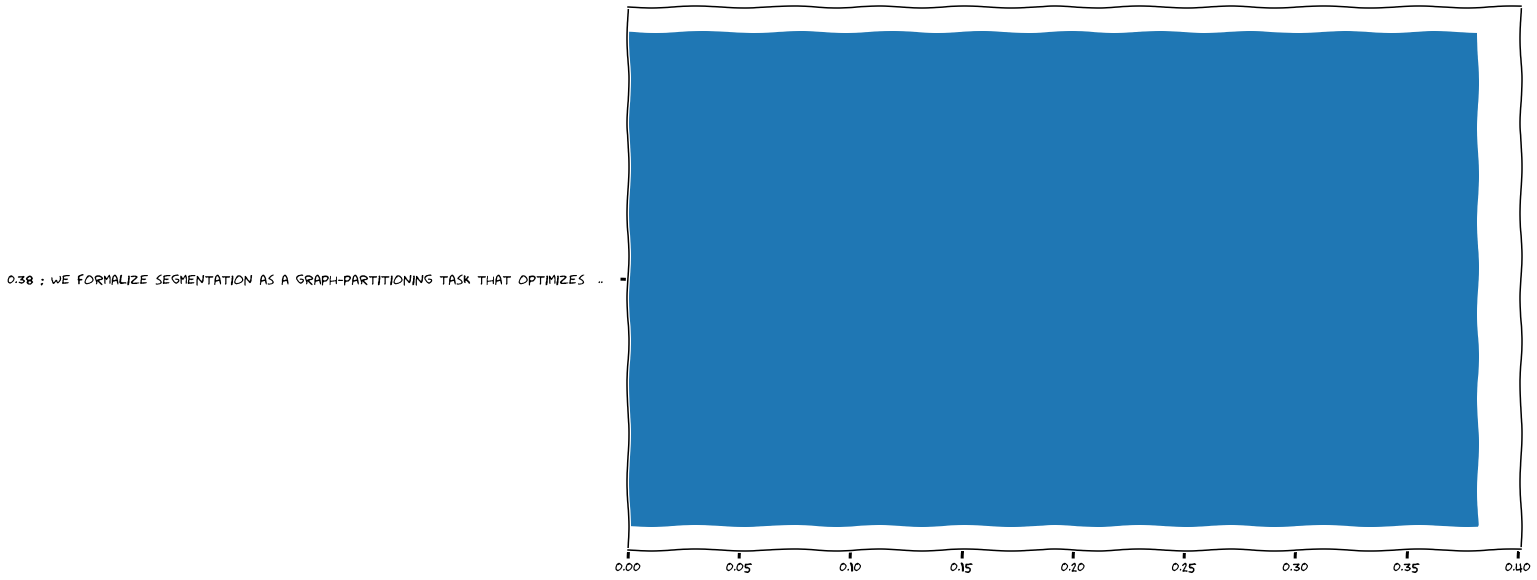

In [ ]:
sent_lenth = 70
score_vals = ([x[0] for x in scores] ) 
sub_sents = [ str(round(score_vals[i],2)) + " : " + sentences[i][:sent_lenth] + " ..  " for i in range(len(sentences))] 
with plt.xkcd():
    plt.figure(figsize=(16,10));
    plt.barh(sub_sents[::-1], score_vals[::-1]);